In [46]:
# Importing libaries for LSTM
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pandas as pd
import matplotlib.pyplot as plt


In [47]:

# Load the dataset
file_path = 'traffic.csv'
df = pd.read_csv(file_path)

# Convert the DateTime column to datetime format
df['DateTime'] = pd.to_datetime(df['DateTime'], errors='coerce')

# Filtering by Junction 1
junction = 1
df_junction = df[df['Junction'] == junction]



In [48]:
# Adding Holidays column 
import holidays
us_holidays = holidays.US(years=[2015, 2016, 2017])
# Extracting Features

df_junction['date'] = df_junction['DateTime'].dt.date
df_junction['hour'] = df_junction['DateTime'].dt.hour
df_junction['weekday'] =  df_junction["DateTime"].dt.strftime("%A")
df_junction['month'] = df_junction['DateTime'].dt.month
df_junction['year'] = df_junction['DateTime'].dt.year
df_junction['isholiday'] = df_junction["date"].isin(us_holidays)

C:\Users\shyam\AppData\Local\Temp\ipykernel_39084\37746459.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_junction['date'] = df_junction['DateTime'].dt.date
C:\Users\shyam\AppData\Local\Temp\ipykernel_39084\37746459.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_junction['hour'] = df_junction['DateTime'].dt.hour
C:\Users\shyam\AppData\Local\Temp\ipykernel_39084\37746459.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexe

In [49]:
# Dropping Redundant and identifier columns
df_junction.drop(["date", "ID", "Junction"], axis=1, inplace=True)

C:\Users\shyam\AppData\Local\Temp\ipykernel_39084\3073033300.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_junction.drop(["date", "ID", "Junction"], axis=1, inplace=True)


In [50]:
# Set DateTime as the index
df_junction.set_index('DateTime', inplace=True)

In [51]:
df_junction.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14592 entries, 2015-11-01 00:00:00 to 2017-06-30 23:00:00
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Vehicles   14592 non-null  int64 
 1   hour       14592 non-null  int32 
 2   weekday    14592 non-null  object
 3   month      14592 non-null  int32 
 4   year       14592 non-null  int32 
 5   isholiday  14592 non-null  bool  
dtypes: bool(1), int32(3), int64(1), object(1)
memory usage: 527.2+ KB


In [52]:
# Label Encoding Categorical columns
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

df_encode = df_junction.copy()

for col in df_encode.columns:
	if df_encode[col].dtype in ['O', 'object', 'category', 'bool']:
		df_encode[col]= encoder.fit_transform(df_encode[col])

In [53]:
df_encode.values

array([[  15,    0,    3,   11, 2015,    0],
       [  13,    1,    3,   11, 2015,    0],
       [  10,    2,    3,   11, 2015,    0],
       ...,
       [  90,   21,    0,    6, 2017,    0],
       [  84,   22,    0,    6, 2017,    0],
       [  78,   23,    0,    6, 2017,    0]], dtype=int64)

In [54]:
# Resampling dataframe date rather then hours
df_daily = df_encode.resample('D').mean(numeric_only=True)

# splittting training and test data
split_date = '1-Feb-2017'
df_train = df_daily.loc[df_daily.index <= split_date].copy()
df_test = df_daily.loc[df_daily.index > split_date].copy()

In [55]:

# Prepare data for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))



In [56]:

# Scaling the data between 0 and 1
train, test = scaler.fit_transform(df_train.values), scaler.fit_transform(df_test.values)



In [57]:
df_encode.head()

,Vehicles,hour,weekday,month,year,isholiday
DateTime,,,,,,
2015-11-01 00:00:00,15,0,3,11,2015,0
2015-11-01 01:00:00,13,1,3,11,2015,0
2015-11-01 02:00:00,10,2,3,11,2015,0
2015-11-01 03:00:00,7,3,3,11,2015,0
2015-11-01 04:00:00,9,4,3,11,2015,0


In [58]:

# Create dataset function
def create_dataset(dataset, look_back=1):
    X, y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:(i + look_back), :])
        y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(y)

# Each input consists of 24 days before the prediction of next day
look_back = 24
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)


In [59]:
X_train.shape

(435, 24, 6)

In [60]:
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

In [61]:
X_test[0]

array([[0.65922747, 0.        , 0.66666667, 0.        , 0.        ,
        0.        ],
       [0.472103  , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.12532189, 0.        , 0.33333333, 0.        , 0.        ,
        0.        ],
       [0.03948498, 0.        , 0.5       , 0.        , 0.        ,
        0.        ],
       [0.5639485 , 0.        , 0.16666667, 0.        , 0.        ,
        0.        ],
       [0.54849785, 0.        , 0.83333333, 0.        , 0.        ,
        0.        ],
       [0.50042918, 0.        , 1.        , 0.        , 0.        ,
        0.        ],
       [0.5888412 , 0.        , 0.66666667, 0.        , 0.        ,
        0.        ],
       [0.49098712, 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.04206009, 0.        , 0.33333333, 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.5       , 0.        , 0.        ,
        0.        ],
       [0.84120172, 0

In [62]:

scaler2 = MinMaxScaler(feature_range=(0, 1))


y_train_sample = scaler2.fit_transform(y_train)
y_test_sample = scaler2.fit_transform(y_test)

In [63]:

# Build the LSTM model with dropout
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(look_back, 6)))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(25))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model with more epochs
model.fit(X_train, y_train, batch_size=1, epochs=100)

# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)


Epoch 1/100
435/435 [==============================] - 7s 7ms/step - loss: 0.0323
Epoch 2/100
435/435 [==============================] - 3s 7ms/step - loss: 0.0201
Epoch 3/100
435/435 [==============================] - 3s 7ms/step - loss: 0.0207
Epoch 4/100
435/435 [==============================] - 3s 7ms/step - loss: 0.0192
Epoch 5/100
435/435 [==============================] - 3s 7ms/step - loss: 0.0169
Epoch 6/100
435/435 [==============================] - 3s 7ms/step - loss: 0.0124
Epoch 7/100
435/435 [==============================] - 3s 7ms/step - loss: 0.0093
Epoch 8/100
435/435 [==============================] - 3s 8ms/step - loss: 0.0085
Epoch 9/100
435/435 [==============================] - 3s 8ms/step - loss: 0.0083
Epoch 10/100
435/435 [==============================] - 3s 8ms/step - loss: 0.0066
Epoch 11/100
435/435 [==============================] - 3s 8ms/step - loss: 0.0071
Epoch 12/100
435/435 [==============================] - 3s 8ms/step - loss: 0.0071
Epoch 13/100


In [70]:
y_test_reshaped = y_test.reshape(125)
test_predict_reshaped = test_predict.reshape(125)

In [66]:
# Inverse Transform

# y_test_reshaped = y_test_reshaped * df_test["Vehicles"].max()
# test_predict_reshaped = test_predict_reshaped * df_test["Vehicles"].max()

In [67]:
y_test_reshaped

array([ 6.25751073, 40.59560086, 53.65815451, 50.68583691, 45.21051502,
       43.64613734,  6.72682403,  5.31888412, 41.847103  , 45.91448498,
       43.41148069, 52.64130901, 40.04806867,  4.84957082,  2.11190987,
       32.06974249, 55.77006438, 51.2333691 , 49.7472103 , 47.00954936,
       15.2526824 , 11.18530043, 60.30675966, 61.40182403, 61.87113734,
       54.675     , 50.06008584, 19.39828326,  7.82188841, 53.03240343,
       54.28390558, 45.60160944, 54.83143777, 38.87478541, 12.827897  ,
       14.70515021, 52.17199571, 59.36813305, 61.48004292, 61.24538627,
       42.78572961, 18.06856223, 19.47650215, 61.63648069, 61.79291845,
       53.42349785, 46.07092275, 25.34291845,  4.22381974,  2.42478541,
       43.48969957, 53.03240343, 58.58594421, 53.11062232, 45.75804721,
       11.02886266, 14.70515021, 56.1611588 , 58.27306867, 55.45718884,
       52.48487124, 34.4945279 ,  5.70997854,  1.4861588 , 25.42113734,
       58.03841202, 56.70869099, 58.27306867, 48.10461373,  5.94

In [71]:


# Performance evaluation
test_mse = mean_squared_error(y_test_reshaped, test_predict_reshaped)
test_mae = mean_absolute_error(y_test_reshaped, test_predict_reshaped)

print(f'Test MSE with dropout: {test_mse}')
print(f'Test MAE with dropout: {test_mae}')

Test MSE with dropout: 0.07849173318337026
Test MAE with dropout: 0.23631036898225163


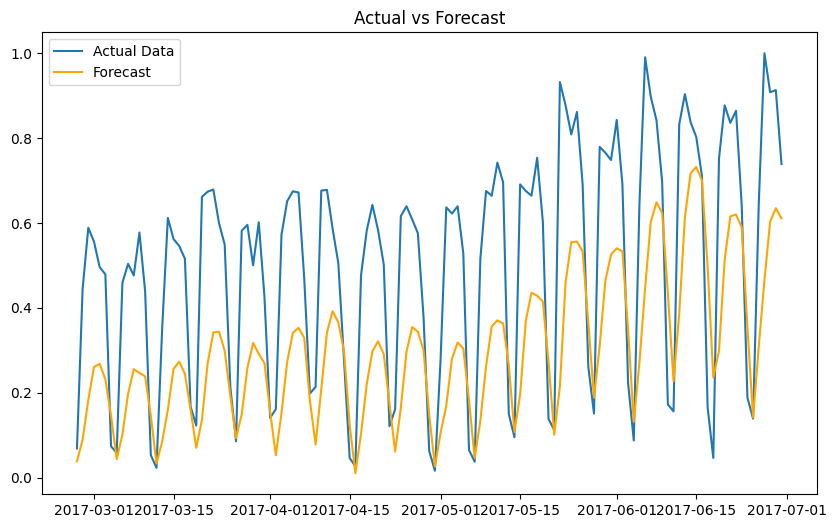

In [72]:
# Plot actual vs forecast
plt.figure(figsize=(10, 6))
plt.plot(df_test.index[24:], y_test_reshaped, label="Actual Data")
plt.plot(df_test.index[24:], test_predict_reshaped, label="Forecast", color="orange")
plt.legend()
plt.title("Actual vs Forecast")
plt.show()

We are getting better results with ARIMA and SARIMA but this is basic model with LSTM it can be further improved